<a href="https://colab.research.google.com/github/kriskalb/flight-delay-prediction/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cartopy
!pip install pyarrow
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.8 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import pyarrow.parquet as pq
import os
import numpy as np
import zipfile
import math
import warnings
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import optuna

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
local_zip = '/content/drive/MyDrive/Kurs/final_project/inputs/flights.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [8]:
# flights = pd.read_csv('/tmp/flights.csv')
airports = pd.read_csv('/content/drive/MyDrive/Kurs/final_project/inputs/airports.csv')
airlines = pd.read_csv('/content/drive/MyDrive/Kurs/final_project/inputs/airlines.csv')

In [ ]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [ ]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [ ]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [ ]:
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [ ]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


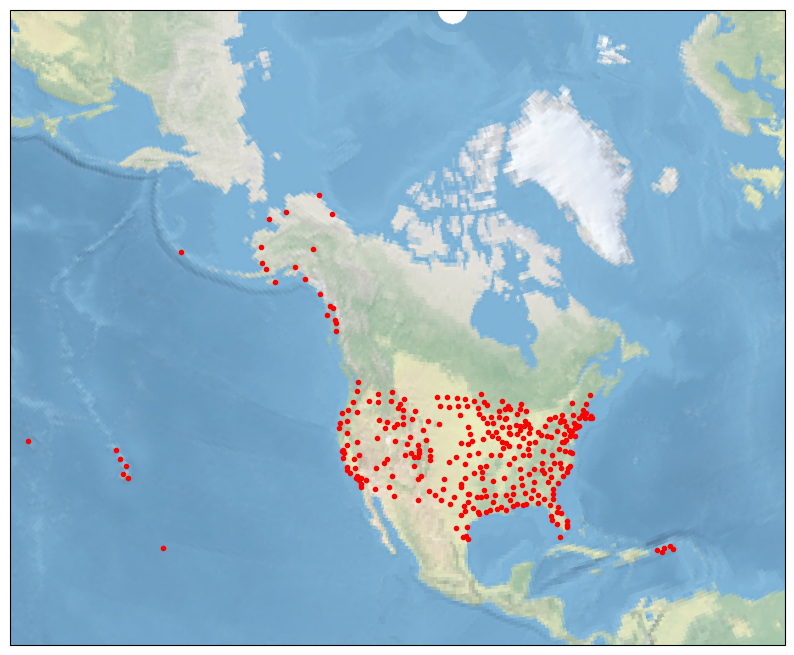

In [ ]:

# Tworzymy mapę w projekcji geograficznej Ameryki Północnej
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-100)})

# Ustalamy granice geograficzne dla Ameryki Północnej
ax.set_extent([-170, -50, 10, 90], ccrs.PlateCarree())

# Zmniejszamy rozmiar znacznika
marker_size = 3

# Dodajemy punkty na mapie
ax.plot(airports['LONGITUDE'], airports['LATITUDE'], 'ro', markersize=marker_size, transform=ccrs.PlateCarree())

# Dodajemy tło mapy
ax.stock_img()

# Wyświetlamy mapę
plt.show()

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    # Promień Ziemi w kilometrach (średni promień)
    radius = 6371.0

    # Zamiana kątów w stopniach na radiany
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Różnice szerokości i długości geograficznych
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Obliczamy odległość za pomocą wzoru Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Obliczamy odległość
    distance = radius * c

    return distance


In [ ]:
# Łączenie 'flights' z 'airports' dla 'ORIGIN_AIRPORT'
df = pd.merge(flights, airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']], left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='inner')
new_column_names = {'LATITUDE': 'ORIG_LATITUDE', 'LONGITUDE': 'ORIG_LONGITUDE'}
df = df.rename(columns=new_column_names)
df = df.drop('IATA_CODE', axis=1)

# Łączenie 'flights' z 'airports' dla 'DESTINATION_AIRPORT'
df = pd.merge(df, airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']], left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='inner')
new_column_names = {'LATITUDE': 'DEST_LATITUDE', 'LONGITUDE': 'DEST_LONGITUDE'}
df = df.rename(columns=new_column_names)
df = df.drop('IATA_CODE', axis=1)


In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,41.0,-4.0,17.0,58.0,204.0,194.0,173.0,1448,451.0,4.0,509,455.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,31.0,-14.0,25.0,56.0,210.0,200.0,171.0,1448,447.0,4.0,515,451.0,-24.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
3,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,NaN,NaN,NaN,NaN,205.0,NaN,NaN,1448,NaN,NaN,600,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,140.0,-15.0,17.0,157.0,218.0,198.0,170.0,1448,547.0,11.0,633,558.0,-35.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931


In [ ]:
df['REAL_DISTANCE'] = df.apply(lambda row: haversine(row['ORIG_LATITUDE'], row['ORIG_LONGITUDE'], row['DEST_LATITUDE'], row['DEST_LONGITUDE']), axis=1)

In [ ]:
df['SCHEDULED_DEPARTURE'].max()

2359

## change miles to kilometres


In [ ]:
df['DISTANCE'] = df['DISTANCE'].apply(lambda dist: 1.609344*dist)

In [ ]:
df['DISTANCE'].mean()

2131.2896424035225

In [ ]:
df['REAL_DISTANCE'].mean()

1323.4628307063126

In [ ]:
df[df['ARRIVAL_DELAY']>30]['ARRIVAL_DELAY'].value_counts().sum()

600323

In [ ]:
df[df['ARRIVAL_DELAY']>30]['DISTANCE'].mean() - df[df['ARRIVAL_DELAY']>30]['REAL_DISTANCE'].mean()


808.3314484760556

In [ ]:
df['ARRIVAL_DELAY'].mean()

4.885903045804635

In [ ]:
df['ARRIVAL_DELAY'].median()

-5.0

In [ ]:
df['DEPARTURE_DELAY'].mean()

9.774567640166886

In [ ]:
df['DEPARTURE_DELAY'].median()

-1.0

In [ ]:
df[df['DEPARTURE_DELAY']>30]['DISTANCE'].mean() - df[df['DEPARTURE_DELAY']>30]['REAL_DISTANCE'].mean()

824.7261813626171

In [ ]:
df[df['DEPARTURE_DELAY']>15]['ELAPSED_TIME'].mean() - df[df['DEPARTURE_DELAY']>15]['SCHEDULED_TIME'].mean()

-4.514710479747578

In [ ]:
df[df['ARRIVAL_DELAY']>15]['ELAPSED_TIME'].mean() - df[df['ARRIVAL_DELAY']>15]['SCHEDULED_TIME'].mean()

4.00422763621836

In [ ]:
df[df['CANCELLATION_REASON'].notna()].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE
3,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,NaN,NaN,NaN,NaN,205.0,NaN,NaN,3750.302784,NaN,NaN,600,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
387,2015,1,25,7,AS,106,N767AS,ANC,SEA,2140,NaN,NaN,NaN,NaN,210.0,NaN,NaN,3750.302784,NaN,NaN,210,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
399,2015,1,26,1,AS,82,N577AS,ANC,SEA,1750,NaN,NaN,NaN,NaN,200.0,NaN,NaN,3750.302784,NaN,NaN,2210,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
416,2015,1,27,2,AS,102,N627AS,ANC,SEA,1910,NaN,NaN,NaN,NaN,203.0,NaN,NaN,3750.302784,NaN,NaN,2333,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
460,2015,1,30,5,AS,102,N611AS,ANC,SEA,1910,NaN,NaN,NaN,NaN,203.0,NaN,NaN,3750.302784,NaN,NaN,2333,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164


In [ ]:
df['CANCELLATION_REASON'][df['CANCELLATION_REASON'].notna()].value_counts()

B    47874
A    24309
C    15225
D       22
Name: CANCELLATION_REASON, dtype: int64

In [ ]:
df[df['ARRIVAL_DELAY']>0].head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE
34,2015,1,3,6,AS,108,N413AS,ANC,SEA,45,138.0,53.0,11.0,149.0,204.0,171.0,156.0,3750.302784,525.0,4.0,509,529.0,20.0,0,0,NaN,0.0,0.0,20.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164
36,2015,1,3,6,AS,136,N306AS,ANC,SEA,135,224.0,49.0,8.0,232.0,205.0,180.0,163.0,3750.302784,615.0,9.0,600,624.0,24.0,0,0,NaN,0.0,0.0,0.0,24.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164
37,2015,1,3,6,AS,134,N459AS,ANC,SEA,155,228.0,33.0,13.0,241.0,218.0,188.0,163.0,3750.302784,624.0,12.0,633,636.0,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
46,2015,1,3,6,AS,82,N530AS,ANC,SEA,1750,1759.0,9.0,8.0,1807.0,197.0,202.0,172.0,3750.302784,2159.0,22.0,2207,2221.0,14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
49,2015,1,4,7,AS,98,N317AS,ANC,SEA,5,41.0,36.0,13.0,54.0,205.0,188.0,170.0,3750.302784,444.0,5.0,430,449.0,19.0,0,0,NaN,0.0,0.0,0.0,19.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164


In [ ]:
df['AIR_SYSTEM_DELAY'][df['AIR_SYSTEM_DELAY']>0].value_counts().sum()

532628

In [ ]:
df['AIRLINE_DELAY'][df['AIRLINE_DELAY']>0].value_counts().sum()

538573

In [ ]:
df['WEATHER_DELAY'][df['WEATHER_DELAY']>0].value_counts().sum()

62610

In [ ]:
df['LATE_AIRCRAFT_DELAY'][df['LATE_AIRCRAFT_DELAY']>0].value_counts().sum()

529110

In [ ]:
df_cancelled = df[df['CANCELLED']==1]

In [ ]:
df = df[df['CANCELLED']==0]
df = df.drop('CANCELLATION_REASON', axis=1)

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,2330.330112,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,41.0,-4.0,17.0,58.0,204.0,194.0,173.0,2330.330112,451.0,4.0,509,455.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,31.0,-14.0,25.0,56.0,210.0,200.0,171.0,2330.330112,447.0,4.0,515,451.0,-24.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,140.0,-15.0,17.0,157.0,218.0,198.0,170.0,2330.330112,547.0,11.0,633,558.0,-35.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,220,209.0,-11.0,15.0,224.0,200.0,199.0,176.0,2330.330112,620.0,8.0,640,628.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164


In [ ]:
df_diverted = df[df['DIVERTED']!= 0]

In [ ]:
df = df[df['DIVERTED']== 0]

In [ ]:
columns_to_fill = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

## columns with the time of individual flight stages in float form

In [ ]:
for column in ['DEPARTURE_TIME', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'WHEELS_ON', 'WHEELS_OFF']:
  df[column] = df[column].astype(int).astype(str).apply(lambda x: ((4 - len(x))*'0')+str(x))
  df[column] = df[column].apply(lambda x: str(int(x[-2:])*(10/6)))
  df[column] = df[column].astype(float).astype(int)

In [ ]:
df['SIN_DEPARTURE_TIME'] = np.sin(2 * np.pi * df['DEPARTURE_TIME'] / 2400)
df['COS_DEPARTURE_TIME'] = np.cos(2 * np.pi * df['DEPARTURE_TIME'] / 2400)
df['SIN_SCHEDULED_DEPARTURE'] = np.sin(2 * np.pi * df['SCHEDULED_DEPARTURE'] / 2400)
df['COS_SCHEDULED_DEPARTURE'] = np.cos(2 * np.pi * df['SCHEDULED_DEPARTURE'] / 2400)
df['SIN_SCHEDULED_ARRIVAL'] = np.sin(2 * np.pi * df['SCHEDULED_ARRIVAL'] / 2400)
df['COS_SCHEDULED_ARRIVAL'] = np.cos(2 * np.pi * df['SCHEDULED_ARRIVAL'] / 2400)
df['SIN_ARRIVAL_TIME'] = np.sin(2 * np.pi * df['ARRIVAL_TIME'] / 2400)
df['COS_ARRIVAL_TIME'] = np.cos(2 * np.pi * df['ARRIVAL_TIME'] / 2400)
df['SIN_WHEELS_ON'] = np.sin(2 * np.pi * df['WHEELS_ON'] / 2400)
df['COS_WHEELS_ON'] = np.cos(2 * np.pi * df['WHEELS_ON'] / 2400)
df['SIN_WHEELS_OFF'] = np.sin(2 * np.pi * df['WHEELS_OFF'] / 2400)
df['COS_WHEELS_OFF'] = np.cos(2 * np.pi * df['WHEELS_OFF'] / 2400)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231130 entries, 0 to 5332913
Data columns (total 36 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             float64
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [ ]:
df.isna().sum()

YEAR                          0
MONTH                         0
DAY                           0
DAY_OF_WEEK                   0
AIRLINE                       0
FLIGHT_NUMBER                 0
TAIL_NUMBER                   0
ORIGIN_AIRPORT                0
DESTINATION_AIRPORT           0
SCHEDULED_DEPARTURE           0
DEPARTURE_TIME                0
DEPARTURE_DELAY               0
TAXI_OUT                      0
WHEELS_OFF                    0
SCHEDULED_TIME                0
ELAPSED_TIME                  0
AIR_TIME                      0
DISTANCE                      0
WHEELS_ON                     0
TAXI_IN                       0
SCHEDULED_ARRIVAL             0
ARRIVAL_TIME                  0
ARRIVAL_DELAY                 0
DIVERTED                      0
CANCELLED                     0
AIR_SYSTEM_DELAY              0
SECURITY_DELAY                0
AIRLINE_DELAY                 0
LATE_AIRCRAFT_DELAY           0
WEATHER_DELAY                 0
ORIG_LATITUDE              4561
ORIG_LON

In [ ]:
df['SIN_DAY_OF_WEEK'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['COS_DAY_OF_WEEK'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['SIN_MONTH'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['COS_MONTH'] = np.cos(2 * np.pi * df['MONTH'] / 12)
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

In [ ]:
df = df.dropna()

In [ ]:
df.groupby('AIRLINE')[['ARRIVAL_DELAY']].mean().sort_values(by='ARRIVAL_DELAY', ascending=False)

,ARRIVAL_DELAY
AIRLINE,
NK,15.225780
F9,13.758930
MQ,7.316540
EV,6.980759
B6,6.949339
OO,6.221438
UA,6.211316
VX,4.979539
WN,4.845657


In [ ]:
airline_company_names = {
    'NK': 0,
    'F9': 1,
    'MQ': 2,
    'EV': 3,
    'B6': 4,
    'OO': 5,
    'UA': 6,
    'VX': 7,
    'WN': 8,
    'AA': 9,
    'US': 10,
    'HA': 11,
    'DL': 12,
    'AS': 13
}
df['AIRLINE_encoded'] = df['AIRLINE'].map(airline_company_names).astype(int)

In [ ]:
df['SIZE_OF_DESTIN_AIRPORT'] = pd.qcut(df.groupby('DESTINATION_AIRPORT')['DESTINATION_AIRPORT'].transform('count'), q=10, labels=False)

In [ ]:
df['SIZE_OF_ORIGIN_AIRPORT'] = pd.qcut(df.groupby('ORIGIN_AIRPORT')['ORIGIN_AIRPORT'].transform('count'), q=10, labels=False)

In [ ]:
columns_to_encode = ['SECURITY_DELAY', 'AIR_SYSTEM_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
for column in  columns_to_encode:
  new_column_name = column + '_encoded'
  df[new_column_name] = df[column].apply(lambda col: 1 if col>0 else 0).astype(int)

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1


In [ ]:
# Backup df
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'

df.to_parquet(parquet_file_path, engine='pyarrow')

In [ ]:
# Backup df_cancelled
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_cancelled.parquet'

df_cancelled.to_parquet(parquet_file_path, engine='pyarrow')

In [ ]:
# Backup df_diverted
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_diverted.parquet'

df_diverted.to_parquet(parquet_file_path, engine='pyarrow')

In [10]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [5]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df_arriving = table.to_pandas()

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,...,0.866025,2015-01-01,12,6,0,0,0,0,0,1
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,...,0.866025,2015-01-01,13,6,0,0,0,0,0,1


In [ ]:
df_arriving.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5222000 entries, 0 to 5332913
Data columns (total 60 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   YEAR                         int64         
 1   MONTH                        int64         
 2   DAY                          int64         
 3   DAY_OF_WEEK                  int64         
 4   AIRLINE                      object        
 5   FLIGHT_NUMBER                int64         
 6   TAIL_NUMBER                  object        
 7   ORIGIN_AIRPORT               object        
 8   DESTINATION_AIRPORT          object        
 9   SCHEDULED_DEPARTURE          int64         
 10  DEPARTURE_TIME               int64         
 11  DEPARTURE_DELAY              float64       
 12  TAXI_OUT                     float64       
 13  WHEELS_OFF                   int64         
 14  SCHEDULED_TIME               float64       
 15  ELAPSED_TIME                 float64       
 16  

In [ ]:
list(df_arriving.columns)

['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY',
 'ORIG_LATITUDE',
 'ORIG_LONGITUDE',
 'DEST_LATITUDE',
 'DEST_LONGITUDE',
 'REAL_DISTANCE',
 'SIN_DEPARTURE_TIME',
 'COS_DEPARTURE_TIME',
 'SIN_SCHEDULED_DEPARTURE',
 'COS_SCHEDULED_DEPARTURE',
 'SIN_SCHEDULED_ARRIVAL',
 'COS_SCHEDULED_ARRIVAL',
 'SIN_ARRIVAL_TIME',
 'COS_ARRIVAL_TIME',
 'SIN_WHEELS_ON',
 'COS_WHEELS_ON',
 'SIN_WHEELS_OFF',
 'COS_WHEELS_OFF',
 'SIN_DAY_OF_WEEK',
 'COS_DAY_OF_WEEK',
 'SIN_MONTH',
 'COS_MONTH',
 'DATE',
 'AIRLINE_encoded',
 'SIZE_OF_DESTIN_AIRPORT',
 'SECURITY_DELAY_en

# First model

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_ORIGIN_AIRPORT']

In [ ]:
len(selected_columns)

20

In [8]:
df_selected = df_arriving[selected_columns]
X = df_arriving[selected_columns]
y = df_arriving['ARRIVAL_DELAY']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model=Ridge(alpha=0.1)
model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [11]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [12]:
r2_lin = r2_score(y_test,y_pred)
r2_lintrain = r2_score(y_train,y_pred_train)

mse_lin = mean_squared_error(y_test,y_pred)
print(f"R2_score: {r2_lin}")
print(f"R2_score (train): {r2_lintrain}")
print(f"Mean Squared Error: {mse_lin}")

R2_score: 0.06044003622357319
R2_score (train): 0.060821079148372204
Mean Squared Error: 1505.6253514795915


In [ ]:
model.coef_

In [ ]:
pd.DataFrame({'Kolumna': X.columns, 'Współczynnik': model.coef_})

# Feature engineering

In [ ]:
df_selected.sample(5)

,DAY,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT
4668147,29,-4.0,135.0,1504.736640,33.43417,-112.00806,36.19837,-95.88824,1501.429165,0.171929,0.985109,0.235990,0.971755,0.974928,-0.222521,-1.000000e+00,-1.836970e-16,8,1,0,7
204583,5,-11.0,220.0,2317.455360,41.97960,-87.90446,33.43417,-112.00806,2313.178992,0.151261,0.988494,0.065403,0.997859,0.433884,-0.900969,-8.660254e-01,-5.000000e-01,1,7,0,8
475739,15,-6.0,47.0,262.323072,19.73877,-156.04563,21.31869,-157.92241,262.782228,0.164187,0.986429,0.107132,0.994245,0.974928,-0.222521,-2.449294e-16,1.000000e+00,11,2,0,1
2469296,29,-5.0,70.0,328.306176,27.97547,-82.53325,25.79325,-80.29056,329.150736,0.235990,0.971755,0.020942,0.999781,-0.433884,-0.900969,5.000000e-01,8.660254e-01,9,3,0,3
660465,3,25.0,146.0,1429.097472,39.85841,-104.66700,41.97960,-87.90446,1425.657403,0.065403,0.997859,0.177085,0.984196,-0.781831,0.623490,5.000000e-01,8.660254e-01,6,8,0,8


In [16]:
df['ARRIVAL_DELAY'].median()

-5.0

In [ ]:
df[df['DATE'] == '2015-12-23']['ARRIVAL_DELAY'].median()

5.0

In [20]:
median_per_day = df.groupby(df['DATE'].dt.date)['ARRIVAL_DELAY'].median().sort_values()
median_per_day[median_per_day>0]

DATE
2015-12-26     1.0
2015-01-02     1.0
2015-06-15     1.0
2015-05-18     1.0
2015-04-10     1.0
2015-04-09     1.0
2015-03-05     1.0
2015-03-06     1.0
2015-02-17     2.0
2015-12-22     2.0
2015-07-18     2.0
2015-08-20     2.0
2015-02-16     3.0
2015-12-28     3.0
2015-06-18     3.0
2015-02-22     3.0
2015-03-02     4.0
2015-01-05     4.0
2015-03-03     4.0
2015-01-12     4.0
2015-01-06     4.0
2015-12-23     5.0
2015-02-26     5.0
2015-12-27     6.0
2015-12-29     6.0
2015-03-01     7.0
2015-12-30     9.0
2015-01-03    11.0
2015-01-04    14.0
Name: ARRIVAL_DELAY, dtype: float64

DATE

* 2015-12-26     1.0  holiday
* 2015-01-02     1.0  holiday
* 2015-06-15     1.0
* 2015-05-18     1.0
* 2015-04-10     1.0
* 2015-04-09     1.0
* 2015-03-05     1.0  extreme weather
* 2015-03-06     1.0  extreme weather
* 2015-02-17     2.0  extreme weather
* 2015-12-22     2.0  holiday
* 2015-07-18     2.0
* 2015-08-20     2.0  
* 2015-02-16     3.0  extreme weather
* 2015-12-28     3.0  holiday
* 2015-06-18     3.0  extreme weather
* 2015-02-22     3.0  holiday
* 2015-03-02     4.0  extreme weather
* 2015-01-05     4.0  holiday
* 2015-03-03     4.0  extreme weather
* 2015-01-12     4.0  holiday
* 2015-01-06     4.0  holiday
* 2015-12-23     5.0  holiday
* 2015-02-26     5.0  holiday
* 2015-12-27     6.0  holiday
* 2015-12-29     6.0  holiday
* 2015-03-01     7.0  extreme weather
* 2015-12-30     9.0  holiday
* 2015-01-03    11.0  holiday
* 2015-01-04    14.0  holiday

In [19]:
df['DATE'].value_counts().sum()

5221218

In [18]:
df['DATE'].value_counts()[:40].sum()

685056

In [23]:
top_df_dates = median_per_day.index

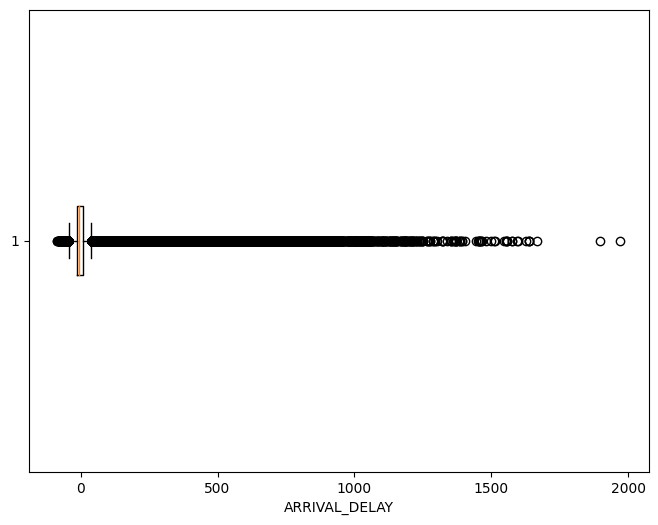

In [ ]:
plt.figure(figsize=(8, 6))  # Opcjonalnie: dostosuj rozmiar wykresu
plt.boxplot(df['DEPARTURE_DELAY'], vert=False)  # vert=False oznacza poziomy wykres pudełkowy

# Dodanie etykiety do osi X
plt.xlabel('DEPARTURE_DELAY')

# Wyświetlenie wykresu
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))  # Opcjonalnie: dostosuj rozmiar wykresu
plt.boxplot(df['ARRIVAL_DELAY'], vert=False)  # vert=False oznacza poziomy wykres pudełkowy

# Dodanie etykiety do osi X
plt.xlabel('ARRIVAL_DELAY')

# Wyświetlenie wykresu
plt.show()

In [11]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_cancelled.parquet'
table = pq.read_table(parquet_file_path)
df_cancelled = table.to_pandas()

In [16]:
df_cancelled.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE
3,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,NaN,NaN,NaN,NaN,205.0,NaN,NaN,2330.330112,NaN,NaN,600,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
387,2015,1,25,7,AS,106,N767AS,ANC,SEA,2140,NaN,NaN,NaN,NaN,210.0,NaN,NaN,2330.330112,NaN,NaN,210,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
399,2015,1,26,1,AS,82,N577AS,ANC,SEA,1750,NaN,NaN,NaN,NaN,200.0,NaN,NaN,2330.330112,NaN,NaN,2210,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
416,2015,1,27,2,AS,102,N627AS,ANC,SEA,1910,NaN,NaN,NaN,NaN,203.0,NaN,NaN,2330.330112,NaN,NaN,2333,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164
460,2015,1,30,5,AS,102,N611AS,ANC,SEA,1910,NaN,NaN,NaN,NaN,203.0,NaN,NaN,2330.330112,NaN,NaN,2333,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,2325.632164


In [27]:
df_cancelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87430 entries, 3 to 5332708
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   YEAR                 87430 non-null  int64         
 1   MONTH                87430 non-null  int64         
 2   DAY                  87430 non-null  int64         
 3   DAY_OF_WEEK          87430 non-null  int64         
 4   AIRLINE              87430 non-null  object        
 5   FLIGHT_NUMBER        87430 non-null  int64         
 6   TAIL_NUMBER          73063 non-null  object        
 7   ORIGIN_AIRPORT       87430 non-null  object        
 8   DESTINATION_AIRPORT  87430 non-null  object        
 9   SCHEDULED_DEPARTURE  87430 non-null  int64         
 10  DEPARTURE_TIME       3616 non-null   float64       
 11  DEPARTURE_DELAY      3616 non-null   float64       
 12  TAXI_OUT             818 non-null    float64       
 13  WHEELS_OFF           818 non-

In [46]:
len(list(df_cancelled['DATE'].unique()))

334

In [12]:
df_cancelled['DATE'] = pd.to_datetime(df_cancelled[['YEAR', 'MONTH', 'DAY']])

In [13]:
df_cancelled['DATE'].value_counts()[:40].sum()

44429

Te 40 dat odpowiada za ok. połowy odwołań lotów.

In [27]:
top_40_cancelled_dates = df_cancelled['DATE'].value_counts().index[:40]

In [15]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_diverted.parquet'
table = pq.read_table(parquet_file_path)
df_diverted = table.to_pandas()

In [16]:
df_diverted['DATE'] = pd.to_datetime(df_diverted[['YEAR', 'MONTH', 'DAY']])

In [35]:
df_diverted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14354 entries, 463 to 5332887
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   YEAR                 14354 non-null  int64         
 1   MONTH                14354 non-null  int64         
 2   DAY                  14354 non-null  int64         
 3   DAY_OF_WEEK          14354 non-null  int64         
 4   AIRLINE              14354 non-null  object        
 5   FLIGHT_NUMBER        14354 non-null  int64         
 6   TAIL_NUMBER          14354 non-null  object        
 7   ORIGIN_AIRPORT       14354 non-null  object        
 8   DESTINATION_AIRPORT  14354 non-null  object        
 9   SCHEDULED_DEPARTURE  14354 non-null  int64         
 10  DEPARTURE_TIME       14354 non-null  float64       
 11  DEPARTURE_DELAY      14354 non-null  float64       
 12  TAXI_OUT             14354 non-null  float64       
 13  WHEELS_OFF           14354 

In [45]:
len(list(df_diverted['DATE'].unique()))

334

In [47]:
df_diverted['DATE'].value_counts()[:65].sum()

6175

Te 65 dat odpowiada za ok. połowy przekierowań lotów.

In [28]:
top_40_diverted_dates = df_diverted['DATE'].value_counts().index[:65]

In [55]:
extreme_dates = list(top_40_diverted_dates) + list(top_40_cancelled_dates)

In [56]:
df['EXTREME_CONDITIONS'] = df['DATE'].isin(extreme_dates).astype(int)

In [56]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0


In [57]:
df['EXTREME_CONDITIONS'].value_counts()

0    3850275
1    1371725
Name: EXTREME_CONDITIONS, dtype: int64

Sprawdzam ile było przypadków kiedy opóźnienie trwało ponad 12h i usuwam te outliers

In [62]:
df[df['ARRIVAL_DELAY']>730]['ARRIVAL_DELAY'].count()

779

In [31]:
df_delayed12h = df[df['ARRIVAL_DELAY']>=730]

In [32]:
df = df[df['ARRIVAL_DELAY']<730]

In [57]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
df.to_parquet(parquet_file_path, engine='pyarrow')
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_cancelled.parquet'
df_cancelled.to_parquet(parquet_file_path, engine='pyarrow')
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_diverted.parquet'
df_diverted.to_parquet(parquet_file_path, engine='pyarrow')

In [26]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_cancelled.parquet'
table = pq.read_table(parquet_file_path)
df_cancelled = table.to_pandas()
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_diverted.parquet'
table = pq.read_table(parquet_file_path)
df_diverted = table.to_pandas()

In [58]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [35]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,1
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,1
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,1
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,1
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,1


# Second model

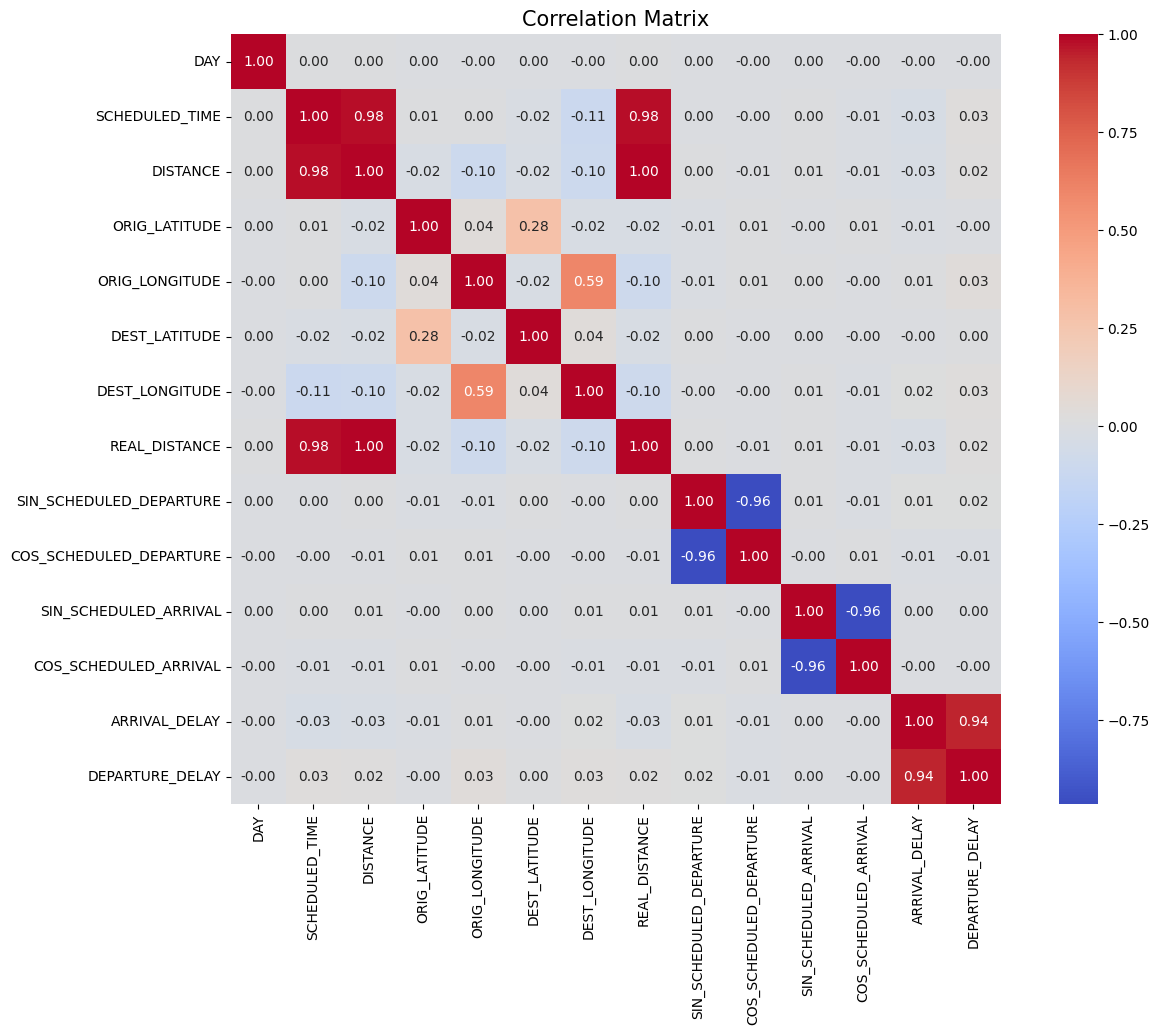

In [6]:
labels_to_corr = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                  'ARRIVAL_DELAY',
                  'DEPARTURE_DELAY']

corr_df = df[labels_to_corr].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title("Correlation Matrix", fontsize=15)
plt.show()

In [7]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0


In [7]:
group_0_conditions = df[df['EXTREME_CONDITIONS'] == 0]['ARRIVAL_DELAY']
group_1_conditions = df[df['EXTREME_CONDITIONS'] == 1]['ARRIVAL_DELAY']
group_0_weather = df[df['WEATHER_DELAY_encoded'] == 0]['ARRIVAL_DELAY']
group_1_weather = df[df['WEATHER_DELAY_encoded'] == 1]['ARRIVAL_DELAY']

# Test t-studenta
t_statistic, p_value = ttest_ind(group_0_conditions, group_1_conditions)
print(f"Test t-studenta - conditions:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")
t_statistic, p_value = ttest_ind(group_0_weather, group_1_weather)
print(f"Test t-studenta - weather:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")


Test t-studenta - conditions:
t-statistic: -264.6888344598106
p-value: 0.0
Test t-studenta - weather:
t-statistic: -556.3914487897043
p-value: 0.0


Wartości t-statystyki są bardzo niskie, co wskazuje na duże różnice między grupami, a p-wartości są bliskie zeru (<0.05), co oznacza, że różnice te są istotne statystycznie.

In [9]:
# Tworzenie grup na podstawie zmiennej kategorycznej
grouped_data = [df['ARRIVAL_DELAY'][df['SIZE_OF_ORIGIN_AIRPORT'] == i] for i in df['SIZE_OF_ORIGIN_AIRPORT'].unique()]
f_statistic, p_value = f_oneway(*grouped_data)
print('SIZE_OF_ORIGIN_AIRPORT:')
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

grouped_data = [df['ARRIVAL_DELAY'][df['SIZE_OF_DESTIN_AIRPORT'] == i] for i in df['SIZE_OF_DESTIN_AIRPORT'].unique()]
f_statistic, p_value = f_oneway(*grouped_data)
print('SIZE_OF_DESTIN_AIRPORT:')
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

grouped_data = [df['ARRIVAL_DELAY'][df['AIRLINE_encoded'] == i] for i in df['AIRLINE_encoded'].unique()]
f_statistic, p_value = f_oneway(*grouped_data)
print('AIRLINE_encoded:')
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")



SIZE_OF_ORIGIN_AIRPORT:
F-statistic: 700.9514243307518
P-value: 0.0
SIZE_OF_DESTIN_AIRPORT:
F-statistic: 378.8956244081768
P-value: 0.0
AIRLINE_encoded:
F-statistic: 2481.110964795245
P-value: 0.0


Wszystkie te wyniki sugerują, że te zmienne kategoryczne mają wpływ na zmienną numeryczną ARRIVAL_DELAY, a różnice między grupami tych zmiennych są istotne statystycznie. Innymi słowy, te zmienne kategoryczne mają wpływ na opóźnienia przyjazdu w analizowanych danych.

In [59]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'EXTREME_CONDITIONS',
                    ]

In [15]:
df_sampled = df.sample(500000).copy()
X = df[selected_columns]
y = df['ARRIVAL_DELAY']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE']
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [73]:
def objective(trial):
    # Definiowanie przestrzeni hiperparametrów
    max_depth = trial.suggest_categorical('max_depth', [10, 11, 12, 13, 14, 15,16,17,18])
    min_samples_split = trial.suggest_categorical('min_samples_split', [10, 11, 12,13,14,15,16,17,18])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [10, 11, 12,13,14, 15,16,17,18])

    # Tworzenie modelu drzewa decyzyjnego do regresji z hiperparametrami
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Trenowanie modelu
    model.fit(X_train, y_train)

    # Prognozowanie na danych testowych
    y_pred = model.predict(X_test)

    # Obliczanie błędu średniokwadratowego (MSE) jako miary jakości
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [74]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-09-25 19:56:32,097] A new study created in memory with name: no-name-d9c738b3-b7f4-44d5-82e2-f4a5983db898
[I 2023-09-25 19:56:36,006] Trial 0 finished with value: 1347.8154989647066 and parameters: {'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 14}. Best is trial 0 with value: 1347.8154989647066.
[I 2023-09-25 19:56:39,392] Trial 1 finished with value: 1330.3126574106886 and parameters: {'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 17}. Best is trial 1 with value: 1330.3126574106886.
[I 2023-09-25 19:56:43,679] Trial 2 finished with value: 1356.964094078789 and parameters: {'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 11}. Best is trial 1 with value: 1330.3126574106886.
[I 2023-09-25 19:56:46,780] Trial 3 finished with value: 1331.3565131970674 and parameters: {'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 12}. Best is trial 1 with value: 1330.3126574106886.
[I 2023-09-25 19:56:51,257] Trial 4 finished with value

In [17]:
best_params = study.best_params

In [18]:
best_model_tree = DecisionTreeRegressor(random_state=42, **best_params)

In [19]:
best_model_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=19, min_samples_split=17,
                      random_state=42)

In [20]:
y_pred_train = best_model_tree.predict(X_train)
y_pred = best_model_tree.predict(X_test)

In [21]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)

In [22]:
print(f"R2_score: {r2}")
print(f"R2_score (train): {r2_train}")
print(f"Mean Squared Error: {mse}")

R2_score: 0.0854728294616457
R2_score (train): 0.08618393388076717
Mean Squared Error: 1329.0077774808672


In [23]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)

In [24]:
mae

20.436286018215796

# Feature Enginnering

In [81]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0


In [91]:
df.groupby(df['ORIGIN_AIRPORT'])['ARRIVAL_DELAY'].median().sort_values(ascending=False).index

Index(['GST', 'ADK', 'PPG', 'ILG', 'AKN', 'OME', 'STC', 'RHI', 'ITH', 'COD',
       ...
       'DLG', 'LSE', 'TOL', 'VEL', 'DIK', 'LAR', 'PSE', 'BTM', 'HYA', 'CNY'],
      dtype='object', name='ORIGIN_AIRPORT', length=319)

In [94]:
origin_airports_to_encode = list(df.groupby(df['ORIGIN_AIRPORT'])['ARRIVAL_DELAY'].median().sort_values(ascending=False).index)

In [95]:
origin_airports_mapping = {}

for i, airport in enumerate(origin_airports_to_encode):
    origin_airports_mapping[airport] = i

In [96]:
df['ORIGIN_AIRPORT_RANK'] = df['ORIGIN_AIRPORT'].map(origin_airports_mapping).astype(int)

In [97]:
destin_airports_to_encode = list(df.groupby(df['DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].median().sort_values(ascending=False).index)

In [98]:
destin_airports_mapping = {}


for i, airport in enumerate(destin_airports_to_encode):
    destin_airports_mapping[airport] = i

In [99]:
df['DESTIN_AIRPORT_RANK'] = df['DESTINATION_AIRPORT'].map(destin_airports_mapping).astype(int)

In [102]:
df.groupby(df['AIRLINE'])['DISTANCE'].median().sort_values()

AIRLINE
HA     262.323072
MQ     585.801216
EV     690.408576
OO     704.892672
WN    1010.668032
DL    1039.636224
US    1047.682944
F9    1440.362880
AS    1535.314176
NK    1540.142208
AA    1577.157120
B6    1627.046784
UA    1713.951360
VX    2222.504064
Name: DISTANCE, dtype: float64

In [103]:
airlines_to_encode_by_distance = list(df.groupby(df['AIRLINE'])['DISTANCE'].median().sort_values().index)

In [104]:
airlines_by_distance_mapping = {}

for i, airline in enumerate(airlines_to_encode_by_distance):
    airlines_by_distance_mapping[airline] = i

In [105]:
df['AIRLINES_BY_DISTANCE'] = df['AIRLINE'].map(airlines_by_distance_mapping).astype(int)

In [106]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0,137,195,5
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8


In [107]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
df.to_parquet(parquet_file_path, engine='pyarrow')

In [2]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [3]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE,REAL_DISTANCE,SIN_DEPARTURE_TIME,COS_DEPARTURE_TIME,SIN_SCHEDULED_DEPARTURE,COS_SCHEDULED_DEPARTURE,SIN_SCHEDULED_ARRIVAL,COS_SCHEDULED_ARRIVAL,SIN_ARRIVAL_TIME,COS_ARRIVAL_TIME,SIN_WHEELS_ON,COS_WHEELS_ON,SIN_WHEELS_OFF,COS_WHEELS_OFF,SIN_DAY_OF_WEEK,COS_DAY_OF_WEEK,SIN_MONTH,COS_MONTH,DATE,AIRLINE_encoded,SIZE_OF_DESTIN_AIRPORT,SECURITY_DELAY_encoded,AIR_SYSTEM_DELAY_encoded,AIRLINE_DELAY_encoded,LATE_AIRCRAFT_DELAY_encoded,WEATHER_DELAY_encoded,SIZE_OF_ORIGIN_AIRPORT,EXTREME_CONDITIONS,ORIGIN_AIRPORT_RANK,DESTIN_AIRPORT_RANK,AIRLINES_BY_DISTANCE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,8,90,-11.0,21.0,25,205.0,194.0,169.0,2330.330112,6,4.0,50,13,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.233445,0.972370,0.020942,0.999781,0.130526,0.991445,0.034027,0.999421,0.015707,0.999877,0.065403,0.997859,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,75,68,-4.0,17.0,96,204.0,194.0,173.0,2330.330112,85,4.0,15,91,-14.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.177085,0.984196,0.195090,0.980785,0.039260,0.999229,0.235990,0.971755,0.220697,0.975342,0.248690,0.968583,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,75,51,-14.0,25.0,93,210.0,200.0,171.0,2330.330112,78,4.0,25,85,-24.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.133121,0.991100,0.195090,0.980785,0.065403,0.997859,0.220697,0.975342,0.202787,0.979223,0.241075,0.970506,-0.433884,-0.900969,0.5,0.866025,2015-01-01,12,6,0,0,0,0,0,1,0,137,195,5
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,91,66,-15.0,17.0,95,218.0,198.0,170.0,2330.330112,78,11.0,55,96,-35.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.171929,0.985109,0.235990,0.971755,0.143493,0.989651,0.248690,0.968583,0.202787,0.979223,0.246153,0.969231,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8
5,2015,1,1,4,AS,114,N303AS,ANC,SEA,33,15,-11.0,15.0,40,200.0,199.0,176.0,2330.330112,33,8.0,66,46,-12.0,0,0,0.0,0.0,0.0,0.0,0.0,61.17432,-149.99619,47.44898,-122.30931,2325.632164,0.039260,0.999229,0.086286,0.996270,0.171929,0.985109,0.120137,0.992757,0.086286,0.996270,0.104528,0.994522,-0.433884,-0.900969,0.5,0.866025,2015-01-01,13,6,0,0,0,0,0,1,0,137,195,8


# Third model

In [4]:
selected_columns = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'SIN_DAY_OF_WEEK',
                    'COS_DAY_OF_WEEK',
                    'SIN_MONTH',
                    'COS_MONTH',
                    'AIRLINE_encoded',
                    'SIZE_OF_DESTIN_AIRPORT',
                    'WEATHER_DELAY_encoded',
                    'SIZE_OF_ORIGIN_AIRPORT',
                    'EXTREME_CONDITIONS',
                    'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',
                    'AIRLINES_BY_DISTANCE']

In [11]:
df_sampled = df.sample(500000).copy()
X = df[selected_columns]
y = df['ARRIVAL_DELAY']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

columns_to_standarize = ['SCHEDULED_TIME', 'DISTANCE', 'ORIG_LATITUDE', 'ORIG_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'ORIGIN_AIRPORT_RANK', 'DESTIN_AIRPORT_RANK']
scaler = StandardScaler()
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])

In [7]:
def objective(trial):

    max_depth = trial.suggest_int('max_depth', 8, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 8, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 8, 20)
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [8]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-09-25 20:50:38,956] A new study created in memory with name: no-name-8e0e7c2d-d0e0-45e6-b34a-b66731de6fe0
[I 2023-09-25 20:50:42,953] Trial 0 finished with value: 1305.1951436329687 and parameters: {'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 10}. Best is trial 0 with value: 1305.1951436329687.
[I 2023-09-25 20:50:48,689] Trial 1 finished with value: 1423.5381176488368 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 1305.1951436329687.
[I 2023-09-25 20:50:53,706] Trial 2 finished with value: 1376.3086868055568 and parameters: {'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 16}. Best is trial 0 with value: 1305.1951436329687.
[I 2023-09-25 20:51:02,761] Trial 3 finished with value: 1353.0428635798773 and parameters: {'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 14}. Best is trial 0 with value: 1305.1951436329687.
[I 2023-09-25 20:51:05,926] Trial 4 finished with value:

In [13]:
best_params = study.best_params
best_model_tree = DecisionTreeRegressor(random_state=42, **best_params)
best_model_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=19, min_samples_split=17,
                      random_state=42)

In [14]:
y_pred_train = best_model_tree.predict(X_train)
y_pred = best_model_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred)
print(f"R2_score: {r2}")
print(f"R2_score (train): {r2_train}")
print(f"Mean Squared Error: {mse}")
print(f"Mean absolute Error: {mae}")

R2_score: 0.0854728294616457
R2_score (train): 0.08618393388076717
Mean Squared Error: 1329.0077774808672
Mean absolute Error: 20.436286018215796


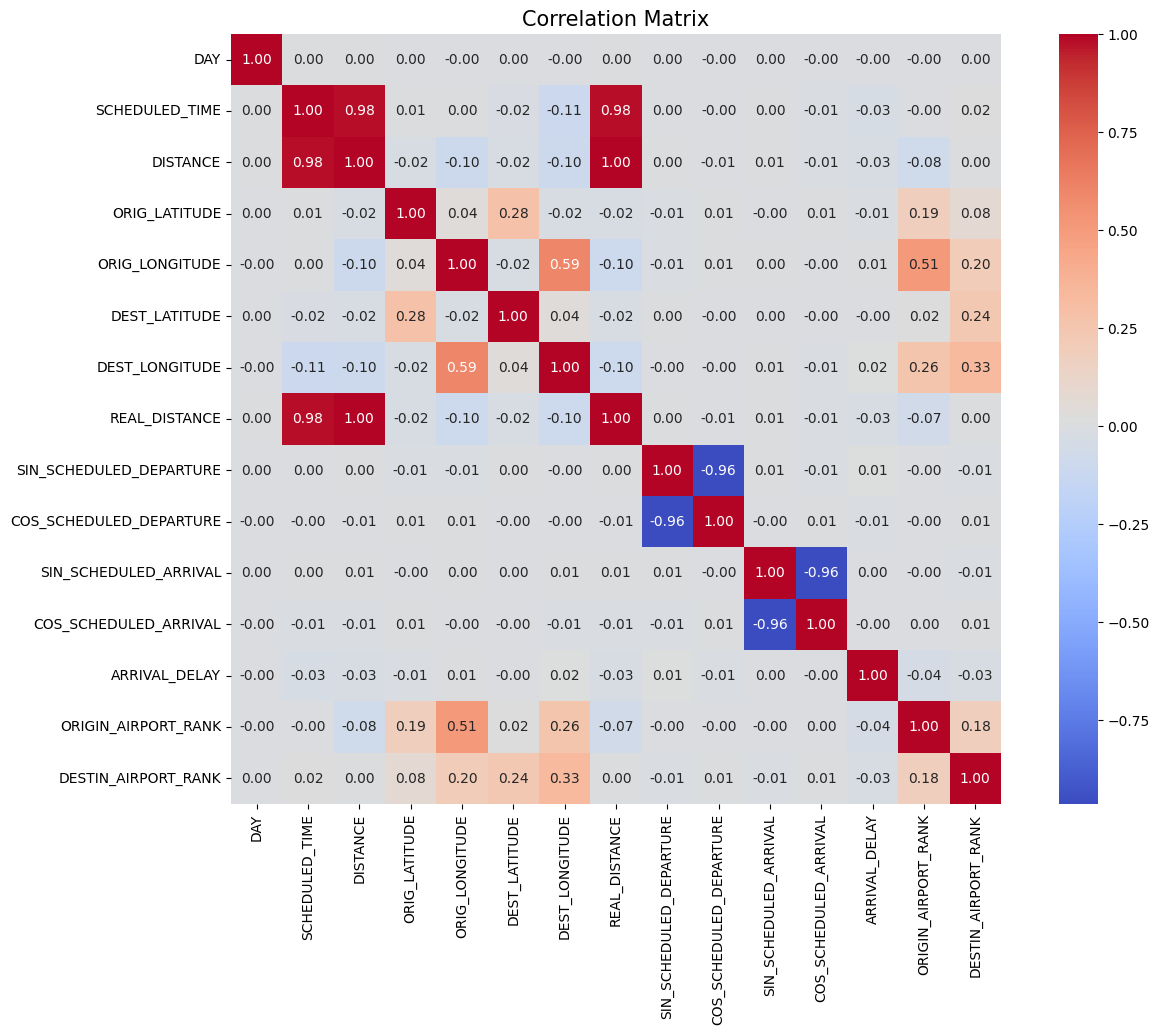

In [25]:
labels_to_corr = ['DAY',
                    'SCHEDULED_TIME',
                    'DISTANCE',
                    'ORIG_LATITUDE',
                    'ORIG_LONGITUDE',
                    'DEST_LATITUDE',
                    'DEST_LONGITUDE',
                    'REAL_DISTANCE',
                    'SIN_SCHEDULED_DEPARTURE',
                    'COS_SCHEDULED_DEPARTURE',
                    'SIN_SCHEDULED_ARRIVAL',
                    'COS_SCHEDULED_ARRIVAL',
                    'ARRIVAL_DELAY',
                    'ORIGIN_AIRPORT_RANK',
                    'DESTIN_AIRPORT_RANK',
                    ]

corr_df = df[labels_to_corr].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title("Correlation Matrix", fontsize=15)
plt.show()

In [28]:
model=Ridge(alpha=1)
model.fit(X_train, y_train)

Ridge(alpha=1)

In [29]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
r2_lin = r2_score(y_test,y_pred)
r2_lintrain = r2_score(y_train,y_pred_train)

mse_lin = mean_squared_error(y_test,y_pred)
print(f"R2_score: {r2_lin}")
print(f"R2_score (train): {r2_lintrain}")
print(f"Mean Squared Error: {mse_lin}")

R2_score: 0.07727810275026703
R2_score (train): 0.0767312910684721
Mean Squared Error: 1340.9165057118078


# Feature Engineering

In [30]:
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_cancelled.parquet'
table = pq.read_table(parquet_file_path)
df_cancelled = table.to_pandas()
parquet_file_path = '/content/drive/MyDrive/Kurs/final_project/inputs/df_diverted.parquet'
table = pq.read_table(parquet_file_path)
df_diverted = table.to_pandas()

In [52]:
df_diverted['DESTINATION_AIRPORT'].value_counts()[:50]

ATL    1113
DFW    1069
ORD     769
DEN     667
IAH     664
LGA     636
MDW     553
MCO     350
BWI     315
LAX     301
EWR     257
SFO     252
HOU     251
JFK     246
DCA     240
MIA     237
SAN     234
PHX     224
LAS     214
DAL     203
PHL     179
SEA     174
TPA     173
ASE     158
CLT     152
BOS     141
SLC     128
MSP     124
MSY     122
SNA     117
AUS     113
BNA     105
DTW     102
STL      98
SUN      95
FLL      87
PDX      79
HPN      71
MCI      71
HNL      68
MKE      68
SJC      62
RSW      61
OKC      59
CMH      54
CLE      53
IAD      53
IND      50
OGG      47
RDU      40
Name: DESTINATION_AIRPORT, dtype: int64

In [36]:
df_diverted['DESTINATION_AIRPORT'].value_counts().sum()

14354

In [47]:
df_diverted['DESTINATION_AIRPORT'].value_counts()[:30].sum()


10263

In [53]:
most_diverted_destinations = list(df_diverted['DESTINATION_AIRPORT'].value_counts()[:50].index)

In [54]:
df['DIVERTED_DESTINATIONS_encoded'] = df['DESTINATION_AIRPORT'].isin(most_diverted_destinations).astype(int)

In [58]:
df_cancelled['ORIGIN_AIRPORT'].value_counts().count()

316

In [56]:
df_cancelled['ORIGIN_AIRPORT'].value_counts().sum()

87430

In [57]:
df_cancelled['ORIGIN_AIRPORT'].value_counts()[:50].sum()

67170

In [59]:
most_cancelled_origin = list(df_cancelled['ORIGIN_AIRPORT'].value_counts()[:50].index)

In [60]:
df['CANCELLED_ORIGIN_encoded'] = df['ORIGIN_AIRPORT'].isin(most_cancelled_origin).astype(int)

In [61]:
df_cancelled['DESTINATION_AIRPORT'].value_counts().sum()

87430

In [62]:
df_cancelled['DESTINATION_AIRPORT'].value_counts()[:50].sum()

69223